In [44]:
import pandas as pd
import json
import cv2
import matplotlib.pyplot as plt

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

In [37]:
df = pd.read_csv('./project-9-at-2023-03-24-09-49-a840689c.csv', sep='\t')
df.label = df.label.apply(json.loads)
df = df[(df.label.apply(lambda x: len(x[0]['points'])) == 4)].iloc[:30]

In [41]:
def load_image(image_path):
    image = cv2.imread(image_path.replace('/data/local-files/?d=', '../data/'))
    return image

In [27]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5
NUM_KEYPOINTS = 2 * 2

In [55]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

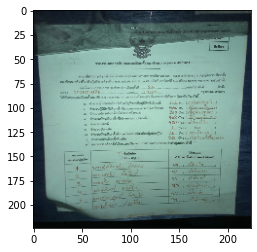

In [56]:
plt.imshow(train_aug(image=load_image(df['image'][0])))

In [25]:
for label in df.label:
    print(label[0])

{'points': [[14.168039538714991, 65.389369592089], [86.49093904448105, 63.906056860321385], [85.33772652388798, 88.62793572311496], [15.815485996705107, 91.84177997527811]], 'closed': True, 'polygonlabels': ['Table'], 'original_width': 768, 'original_height': 1024}
{'points': [[18.12191103789127, 44.6229913473424], [76.11202635914333, 43.63411619283065], [76.77100494233937, 65.26576019777504], [18.616144975288304, 66.13102595797281]], 'closed': True, 'polygonlabels': ['Table'], 'original_width': 768, 'original_height': 1024}
{'points': [[18.945634266886326, 35.22867737948083], [75.28830313014826, 35.35228677379481], [75.61779242174629, 91.47095179233622], [19.934102141680395, 92.45982694684795]], 'closed': True, 'polygonlabels': ['Table'], 'original_width': 768, 'original_height': 1024}
{'points': [[20.757825370675455, 46.47713226205192], [75.61779242174629, 46.47713226205192], [75.45304777594728, 66.87268232385661], [20.75782537067545, 66.74907292954265]], 'closed': True, 'polygonlabe